Title: Box 2

Author: Ruth Hanna

Email: rhanna@broadinstitute.org; jdoench@broadinstitute.org

Date: 2019-07-08


This notebook contains the code used to generate the figures in Box 2.

In [1]:
import pandas as pd 
import numpy as np
from numpy.random import normal
import random
from math import floor, log
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,gaussian_kde
import matplotlib

matplotlib.rc('pdf', fonttype=42)
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

We use pDNA sequencing data from the Brunello library as a starting point for this analysis. These data are available in Supplementary Data File 1 of Sanson et al. 2018 (https://www.nature.com/articles/s41467-018-07901-8).

In [2]:
# Load the pDNA raw read counts
df = pd.read_csv('/Users/rhanna/software-tools/brunello_pdna.txt',sep='\t')
df.head()

,sgRNA Sequence,pDNA
0,AAAAAAAATCCGGACAATGG,522
1,AAAAAAAGGATGGTGATCAA,511
2,AAAAAAATGACATTACTGCA,467
3,AAAAAAATGTCAGTCGAGTG,200
4,AAAAAACACAAGCAAGACCG,286


To simulate random noise, we generate a normal distribution centered at 1 with a standard deviation of 0.1. We then multiple each row of the pDNA reads by this random factor. We do this twice, to simulate two "replicates."

In [3]:
def add_randomness(row):
    rand = normal(1,0.1)
    return row['pDNA']*rand

df['A'] = df.apply(add_randomness,axis=1)
df['B'] = df.apply(add_randomness,axis=1)

We then log-transform the raw read counts for each "replicate" and for the original pDNA.

In [4]:
def get_lognorm(scores):
    cols = list(scores)[1:]
    for col in cols:
        # Calculate the log-normalized reads per million
        # Add a pseudocount of 1
        scores[col + ';lognorm'] = scores[col].apply(lambda x: log(float(x)/float(scores[col].sum())*1000000 + 1,2))
    return scores

df = get_lognorm(df)
df.head()

,sgRNA Sequence,pDNA,A,B,pDNA;lognorm,A;lognorm,B;lognorm
0,AAAAAAAATCCGGACAATGG,522,524.610325,434.718135,4.192756,4.199903,3.945118
1,AAAAAAAGGATGGTGATCAA,511,568.112368,556.651342,4.163726,4.308809,4.281147
2,AAAAAAATGACATTACTGCA,467,489.719104,471.516081,4.041390,4.106193,4.055016
3,AAAAAAATGTCAGTCGAGTG,200,197.883850,214.722432,2.930437,2.917429,3.020419
4,AAAAAACACAAGCAAGACCG,286,265.143905,266.355669,3.388394,3.290277,3.296414


To get log-fold-change values for each "replicate," we subtract off the log-normalized read counts for the pDNA.

In [5]:
df['A-pDNA'] = df['A;lognorm'] - df['pDNA;lognorm']
df['B-pDNA'] = df['B;lognorm'] - df['pDNA;lognorm']
df.head()

,sgRNA Sequence,pDNA,A,B,pDNA;lognorm,A;lognorm,B;lognorm,A-pDNA,B-pDNA
0,AAAAAAAATCCGGACAATGG,522,524.610325,434.718135,4.192756,4.199903,3.945118,0.007147,-0.247638
1,AAAAAAAGGATGGTGATCAA,511,568.112368,556.651342,4.163726,4.308809,4.281147,0.145083,0.117421
2,AAAAAAATGACATTACTGCA,467,489.719104,471.516081,4.041390,4.106193,4.055016,0.064804,0.013626
3,AAAAAAATGTCAGTCGAGTG,200,197.883850,214.722432,2.930437,2.917429,3.020419,-0.013009,0.089981
4,AAAAAACACAAGCAAGACCG,286,265.143905,266.355669,3.388394,3.290277,3.296414,-0.098117,-0.091980


Finally, we plot the replicate correlations for the log-normalized reads and the log-fold-change values. The log-normalized reads are highly correlated due to the underlying distribution of the pDNA. However, the log-fold-change values show that there is no true signal.

In [6]:
def plot_fig(x,y,name,ticks,xlabel,ylabel):
    corr = np.round(pearsonr(x, y)[0],2)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=20, edgecolor='')
    lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(1,0.05,'r = '+str(corr),fontsize=12,ha='right',va='bottom',transform=ax.transAxes)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    fig.savefig('/Users/rhanna/software-tools/'+name+'.pdf')
    plt.show()
    return fig,ax

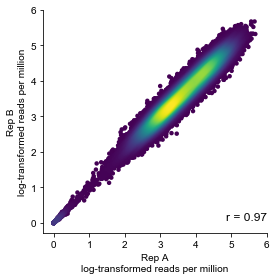

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118400e10>)

In [7]:
x = df['A;lognorm']
y = df['B;lognorm']

plot_fig(x=x,
         y=y,
         name='lognorm',
         ticks=[0,2,4,6],
         xlabel='Rep A\nlog-transformed reads per million',
         ylabel='Rep B\nlog-transformed reads per million')

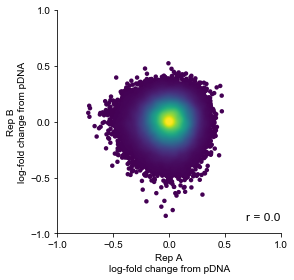

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ad34d90>)

In [8]:
x = df['A-pDNA']
y = df['B-pDNA']

plot_fig(x=x,
         y=y,
         name='lfc',
         ticks=[-1,0,1],
         xlabel='Rep A\nlog-fold change from pDNA',
         ylabel='Rep B\nlog-fold change from pDNA')

In [9]:
df.to_csv('/Users/rhanna/software-tools/box2.csv',index=False)

Next, we generate example replicate correlation plots showing good replicate correlations for negative and positive selection screens. Again, we use data from Sanson et al. 2018, Supplementary Data File 5. The negative selection screen is A375 cells screened with the Calabrese library in XPR_118 in the absence of drug; the positive selection screen is the vemurafenib-treated arm of that same screen.

Again, we calculate log-normalized reads per million and log-fold-change values for each guide and then generate replicate correlation plots.

In [10]:
data = pd.read_csv('/Users/rhanna/software-tools/neg_pos_sel.txt',sep='\t')
data.head()

,sgRNA Sequence,pDNA,NoDrugA,NoDrugB,VemA,VemB
0,AAAAAAAAAAAGCACTCTGT,82,140,216,68,37
1,AAAAAAAAAAGCAGTGGGAG,122,343,250,90,22
2,AAAAAAAAAAGGTCATTCAG,108,179,251,63,42
3,AAAAAAAAAATGTCAGAAGC,138,224,242,71,80
4,AAAAAAAAACAGGTCACCCA,118,283,281,77,80


In [11]:
data = get_lognorm(data)

In [12]:
for col in list(data)[7:]:
    data[str(col.split(';')[0]) + '_lfc'] = data[col] - data['pDNA;lognorm']
data['VemA;lfc_dropout'] = data['VemA;lognorm'] - data['NoDrugA;lognorm']
data['VemB;lfc_dropout'] = data['VemB;lognorm'] - data['NoDrugB;lognorm']

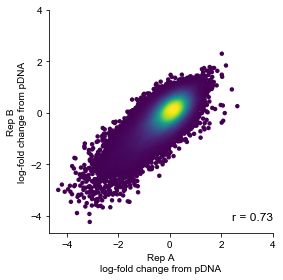

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ba95fd0>)

In [13]:
x=data['NoDrugA_lfc']
y=data['NoDrugB_lfc']
plot_fig(x=x,y=y,name='no_drug_lfc',ticks=[-4,-2,0,2,4],xlabel='Rep A\nlog-fold change from pDNA',ylabel='Rep B\nlog-fold change from pDNA')


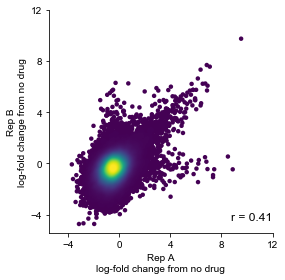

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c47a750>)

In [16]:
x=data['VemA;lfc_dropout']
y=data['VemB;lfc_dropout']
plot_fig(x=x,y=y,name='vem_lfc',ticks=[-4,0,4,8,12],xlabel='Rep A\nlog-fold change from no drug',ylabel='Rep B\nlog-fold change from no drug')

In [17]:
data.to_csv('/Users/rhanna/software-tools/box2_neg_pos_sel.csv',index=False)